# RLab03 - Gabriele Bertinelli (2103359)

In [ ]:
library(tidyverse)
library(gridExtra)
library(latex2exp)
library(emdbook)
library(bayestestR)
library(coda)
library(magrittr)

set.seed(2103359)

#### 1)  
**1.1)** The probability distribution (in our case the likelihood) of *y*, the number of times the new method fails to detect the disease (i.e. false negatives), follows a Binomial distribution $P(y|\pi) = \binom{n}{y} \pi^y (1-\pi)^{(n-y)}$, where
- n: number of trials
- y: number of missed detections (FN)
- $\pi$: probability of a single missed detection (unknown)  

**1.2)** Frequentist estimator of failure probability: $\hat{p}_{new} = y/n = 6/75 = 0.08$. The new method fails to detect the disease in approximately 8% of the cases according to the frequentist approach. This is an estimate based on a specific sample. The true failure probability might be slightly higher or lower than 0.08.

**1.3)** Bayesian approach using a Beta prior with $\mu=p=0.15$ and $\sigma = 0.14$. We found $\alpha$ and $\beta$ solving the system:
$$\begin{array}{lcl}\alpha + \beta + 1 &=& \frac{p(1-p)}{\sigma^2} \\\\ \alpha + \beta &=& \frac{\alpha}{p} \end{array}$$

Warning message:
"Removed 45 rows containing missing values or values outside the scale range
(`geom_line()`)."


[1] "The posterior mean is 0.08"
[1] "The posterior variance is 0.00095"


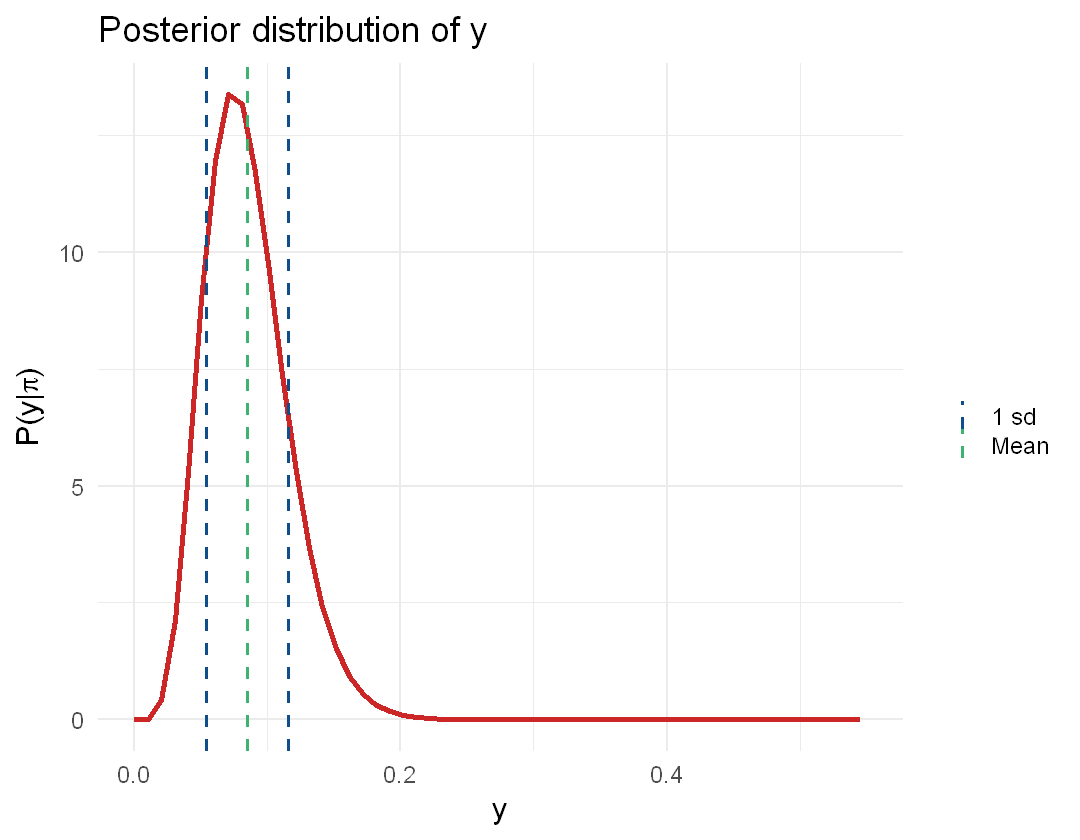

In [2]:
n <- 75
y <- 6
mu <- 0.15
sigma <- 0.14

prior.alpha <- ((mu*(1-mu))/sigma^2 - 1)*mu
prior.beta <- prior.alpha * (1/mu - 1)

post.alpha <- prior.alpha + y
post.beta <- prior.beta + n - y

post.mean <- post.alpha / (post.alpha + post.beta)
post.variance <- post.alpha * post.beta / ((post.alpha + post.beta)^2 * (post.alpha + post.beta + 1))

x <- seq(0, 1, length.out = 100)
fn.pdf <- dbeta(x, post.alpha, post.beta)

options(repr.plot.width = 9, repr.plot.height = 7)
fn.plot <- ggplot() + 
			geom_line(aes(x = x, y = fn.pdf), color='firebrick3', lwd=1.5) +
			geom_vline(aes(xintercept = post.mean, color='Mean'), lwd=1, linetype='dashed') +
			geom_vline(aes(xintercept = post.mean-sqrt(post.variance), color='1 sd'), lwd=1, linetype='dashed') + 
			geom_vline(aes(xintercept = post.mean+sqrt(post.variance), color='1 sd'), lwd=1, linetype='dashed') +
			labs(title = 'Posterior distribution of y', x = 'y', y = TeX(r'(P(y|\pi))'), color='') +
			xlim(c(0, 0.55)) +
			theme_minimal(base_size = 18) +
			scale_color_manual(values=c('Mean'= 'mediumseagreen', '1 sd'= 'dodgerblue4' ))

fn.plot

print(sprintf('The posterior mean is %.2f', post.mean))
print(sprintf('The posterior variance is %.5f', post.variance))

**1.4.1)** <u>Bayes Factor</u>

In [3]:
null.model <- 0.15

fn.pdf <- function(x) dbeta(x, post.alpha, post.beta)

# Calculate Bayes Factor using numerical integration
#integrate the posterior over H0 (p >= 0.15) and H1 (p < 0.15) regions
h0.integral <- integrate(fn.pdf, lower = null.model, upper = 1)$value
h1.integral <- integrate(fn.pdf, lower = 0, upper = null.model)$value

bayes.factor <- h1.integral / h0.integral

cat("Bayes Factor:", bayes.factor, "\n")

# Interpret Bayes Factor (example thresholds)
if (bayes.factor > 3) {
  cat("New test might be better than the old method (H1 favored - P(y)<0.15) -> reject null hypothesis.")
} else if (bayes.factor < 1/3) {
  cat("New test is not necessarily better than the old method (H0 favored - P(y)>=0.15) -> accept null hypotesis.")
} else {
  cat("The data is inconclusive. More data or a different prior might be needed.")
}


Bayes Factor: 30.96999 
New test might be better than the old method (H1 favored - P(y)<0.15) -> reject null hypothesis.

Using as reference Table 16.1 of https://mspeekenbrink.github.io/sdam-book/ch-Bayes-factors.html, a Bayes Factor of 30.96 suggests very strong evidence for MODEL 1, which is the alternative hypothesis H1.

**1.4.2)** <u>Credible Interval</u> - We used a one-side credible interval test: if the bound of the credible interval is less than 0.15, it suggests that the new method is significantly better than the traditional method at detecting the disease in patients.

Null hypothesis is rejected. The new method is significantly better than the old method.

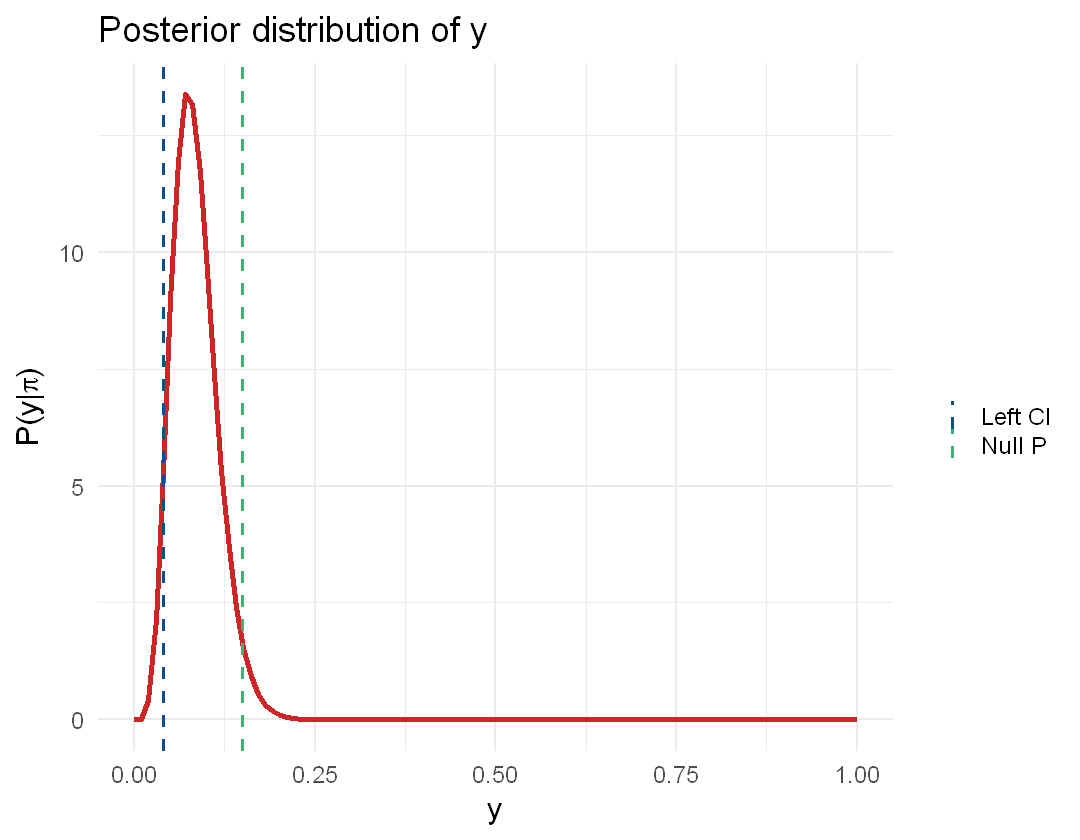

In [4]:
# Left-tailed Credible Interval Calculation
left_credible <- qbeta(0.05, post.alpha, post.beta)

# Hypothesis Testing
if (left_credible > null.model) {
  cat("Null hypothesis cannot be rejected. The new method is not significantly better than the old method.")
} else {
  cat("Null hypothesis is rejected. The new method is significantly better than the old method.")
}

x <- seq(0, 1, length.out = 100)
fn.pdf <- dbeta(x, post.alpha, post.beta)

# Plotting Posterior Distribution
ci.plot <- ggplot() + 
	geom_line(aes(x=x, y=fn.pdf), color='firebrick3', lwd=1.5) +
	geom_vline(aes(xintercept= left_credible, col = "Left CI"), linetype = "dashed", lwd=1) +
	geom_vline(aes(xintercept = null.model, col = "Null P"), linetype = "dashed", lwd=1) +
	labs(title = 'Posterior distribution of y', x = 'y', y = TeX(r'(P(y|\pi))'), color='') +
	theme_minimal(base_size = 18) +
	scale_color_manual(values=c('Left CI'= 'dodgerblue4', 'Null P'= 'mediumseagreen' ))

ci.plot

**1.5)**

In [5]:
# Perform one-tailed Binomial test
p_value <- pbinom(y, n, 0.15) # P(y <= 6 | p = 0.15)
cat("p-value:", p_value, "\n")

alpha <- 0.05
if (p_value < alpha) {
  cat("New test might be better than the old method (H1 favored - P(y)<0.15) -> reject null hypothesis.")
} else {
  cat("Fail to reject H0. The data is inconclusive about the new test's performance at the 5% significance level.")
}

p-value: 0.0543533 
Fail to reject H0. The data is inconclusive about the new test's performance at the 5% significance level.

In [6]:
# Perform one-tailed Binomial test using binom.test
bin.test <- binom.test(x = y, n = n, p = 0.15, conf.level=0.95, alternative = "less")

cat("p-value:", bin.test$p.value, "\n")
cat("Confidence Interval:", bin.test$conf.int, "\n")

if (bin.test$p.value < alpha) {
  cat("New test might be better than the old method (H1 favored - P(y)<0.15) -> reject null hypothesis.")
} else {
  cat("Fail to reject H0. The data is inconclusive about the new test's performance at the 5% significance level.")
}


p-value: 0.0543533 


Confidence Interval: 0 0.1517971 
Fail to reject H0. The data is inconclusive about the new test's performance at the 5% significance level.

#### 2)

In [7]:
mcmc <- function(func = func, x = x, mu.init = mu.init, sigma = sigma2, n.iter = n.iter, burn.in = burn.in) {
  # Initialize chain and acceptance counter
  mu.cur <- mu.init
  func.samp <- matrix(data=NA, nrow=n.iter, ncol=4)
  func.samp[1:2, 2] <- c(mu.cur, mu.cur)
  n.acc <- 0
  acc.rate <- 0
  
  func.samp[1:2, 1] <- c(1, 2)
  # Loop for MCMC iterations
  for (i in 3:n.iter) {
    # Propose new value for mu
    mu.prop <- rnorm(1, func.samp[i-1, 2], sd = sigma2)  # Adjust proposal SD as needed
    
    # Calculate acceptance probability ratio
    rho <- min(1, func(x, mu.prop, sigma2) / func(x, func.samp[i-1, 2], sigma2)) 

    # Accept or reject proposal based on uniform random draw
    u <- runif(1)
    if (u < rho) {
      func.samp[i, 2] <- mu.prop
      n.acc <- n.acc + 1
    } else {
      func.samp[i, 2] <- func.samp[i-1, 2]
    }
	func.samp[i, 1]	<- i
	func.samp[i, 3] <- n.acc
	func.samp[i, 4] <- n.acc / i
  }
  
  # Remove burn-in (initial samples for convergence)
  func.samp <- func.samp[round(n.iter * burn.in):n.iter, ]  # Adjust burn-in proportion
  
  # Return MCMC chain, acceptance rate, and ACF
  return(func.samp)
}

In [8]:
# Define the likelihood function (assuming unknown mean mu)
likelihood <- function(x, mu, sigma2) {
  return(dnorm(x, mean = mu, sd = sqrt(sigma2)))
}

# Define the prior function (piecewise)
prior <- function(mu) {
	sapply(mu, function(mu) {
		
		if (mu > 0 & mu <= 3) {
			mu
		} else if (mu > 3 & mu <= 5) {
			3
		} else if (mu > 5 & mu <= 8) {
			8 - mu
		} else {
			0
		}
	} )
}

testfunc <- function(x, mu, sigma2) {

	# integral <- integrate(function(x) {
	# 	prior(mu) * likelihood(x, mu, sigma2)
	# }, lower = -Inf, upper = Inf)$value
	# mcmc doesn't like the normalization constant

	return((prior(mu) * likelihood(x, mu, sigma2)))
}

testfunc.metr <- function(x, mu, sigma2) {
	return(log10(testfunc(x, mu, sigma2)))
}

In [9]:
sigma2 <- 2^2  # Known variance
x <- c(4.09, 4.68, 1.87, 2.62, 5.58, 8.68, 4.07, 4.78,
4.79, 4.49, 5.85, 5.09, 2.40, 6.27, 6.30, 4.47)
mu.init <- 4.5  # Initial value for mu

test.chain <- mcmc(func = testfunc, x = x, mu.init = mu.init, sigma = sigma2, n.iter = 100000, burn.in = 0.25) 
test.chain <- as.data.frame(test.chain)
colnames(test.chain) <- c('it', 'mu', 'n.acc', 'acc.rate')

In [10]:
posterior.mean <- mean(test.chain$mu)

posterior.median <- median(test.chain$mu)

posterior.sd <- sd(test.chain$mu)

cat("Posterior Mean:", round(posterior.mean, 2), "\n")
cat("Posterior Median:", round(posterior.median, 2), "\n")
cat("Posterior Standard Deviation:", round(posterior.sd, 2), "\n")

Posterior Mean: 4.65 
Posterior Median: 4.71 
Posterior Standard Deviation: 1.01 


In [11]:
cred.int <- quantile(test.chain$mu, c(0.025, 0.975))

cat("95% Credible Interval:", round(cred.int[1], 2), '-', round(cred.int[2], 2), "\n")

95% Credible Interval: 2.64 - 6.6 


Acceptance Rate: 0.18045 


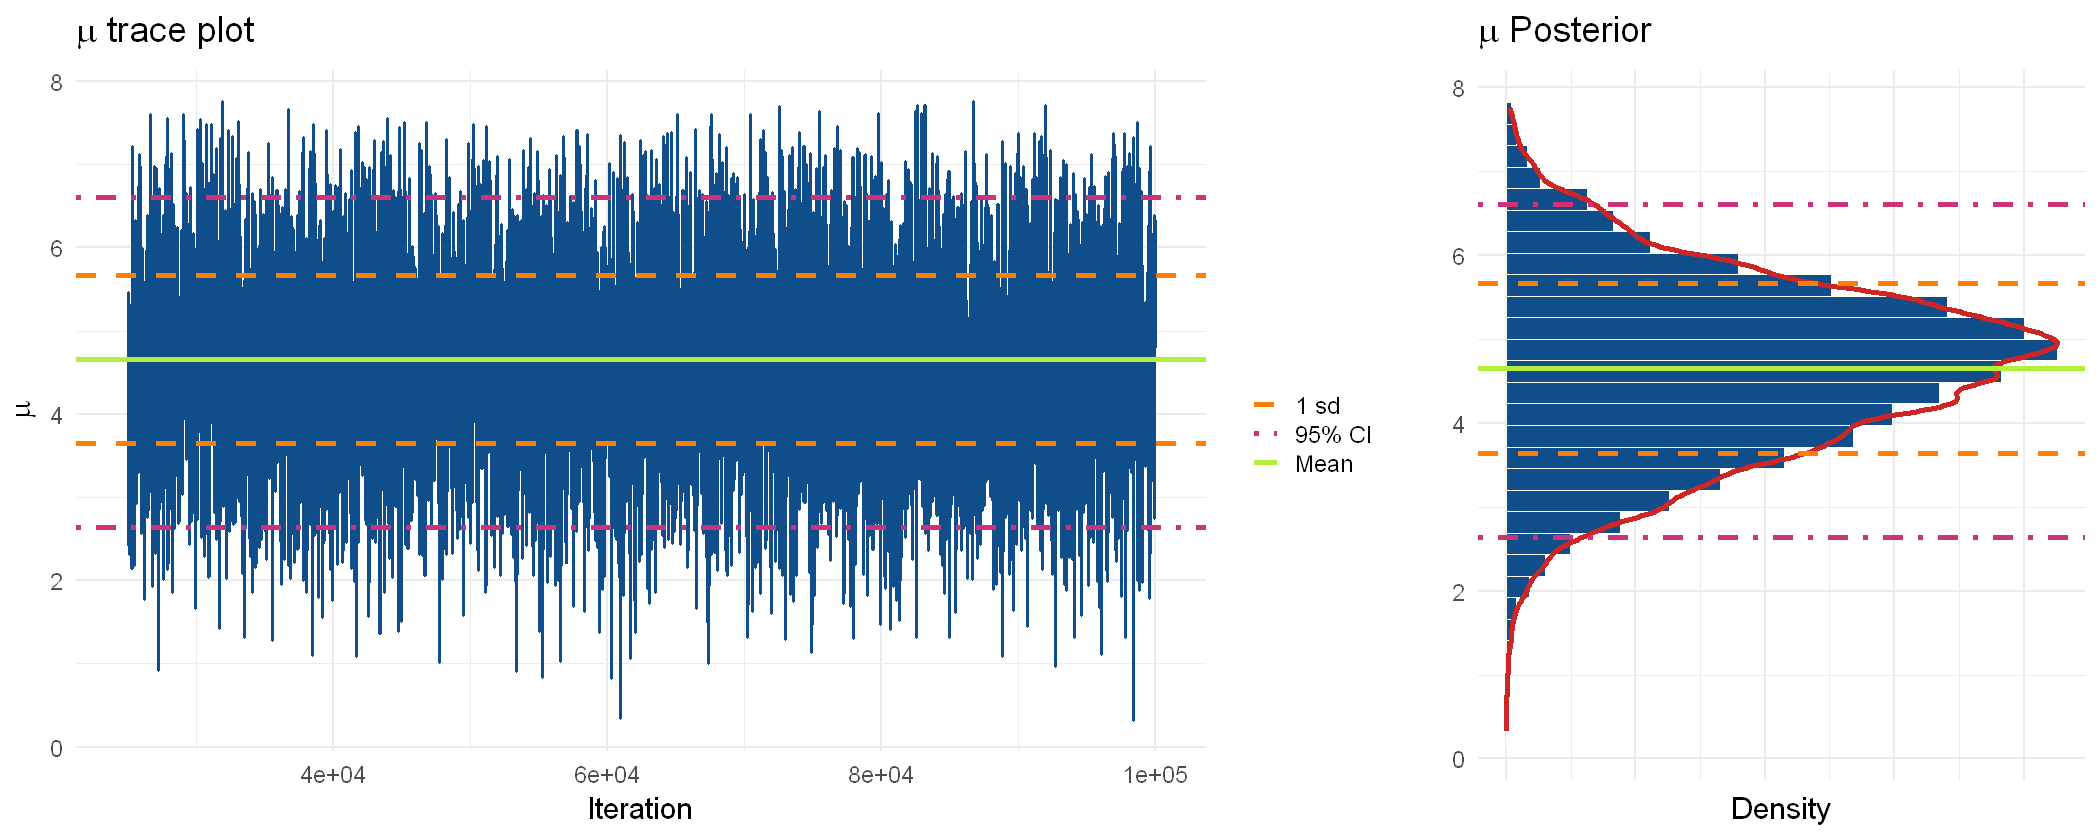

In [12]:
# Print acceptance rate
cat("Acceptance Rate:", tail(test.chain$acc.rate, 1), "\n")

options(repr.plot.width = 17.5, repr.plot.height = 7)

# Custom layout
layout <- matrix(c(1, 1, 2), ncol = 3, byrow = TRUE)

# Visualize posterior distribution
post.hist <- ggplot(data = test.chain) +
	geom_histogram(aes(x = mu, after_stat(density)), bins = 30, color = "ivory", fill = "dodgerblue4") +
	geom_density(aes(x = mu), color = "firebrick3", lwd = 1.5) +
	geom_vline(aes(xintercept = posterior.mean, color='Mean'), lwd=1.5)+
	geom_vline(aes(xintercept = posterior.mean - posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	geom_vline(aes(xintercept = posterior.mean + posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	# geom_vline(aes(xintercept = posterior.median, color='Median'), lwd=1.5) +
	geom_vline(aes(xintercept = cred.int[1], color='95% CI'), lwd=1.5, linetype='dotdash') +
	geom_vline(aes(xintercept = cred.int[2], color='95% CI'), lwd=1.5, linetype='dotdash') +
	labs(title = TeX(r"(\mu Posterior)"), x = '', y = "Density") +
	scale_color_manual(values = c('Mean' = 'olivedrab2', '1 sd' = '#FF7F00', '95% CI' = 'violetred3')) +
	theme_minimal(base_size = 18) + theme(axis.text.x=element_blank(), legend.position="none") + coord_flip()

trace.plot <- ggplot(data = test.chain) +
	geom_line(aes(x = it, y = mu), color = "dodgerblue4", lwd=1) +
	geom_hline(aes(yintercept = posterior.mean, color='Mean'), lwd=1.5)+
	geom_hline(aes(yintercept = posterior.mean - posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	geom_hline(aes(yintercept = posterior.mean + posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	# geom_hline(aes(yintercept = posterior.median, color='Median'), lwd=1.5) +
	geom_hline(aes(yintercept = cred.int[1], color='95% CI'), lwd=1.5, linetype='dotdash') +
	geom_hline(aes(yintercept = cred.int[2], color='95% CI'), lwd=1.5, linetype='dotdash') +
	labs(title = TeX(r"(\mu trace plot)"), x = "Iteration", y = TeX(r"(\mu)"), color='', lwd=1.5) +
	scale_color_manual(values = c('Mean' = 'olivedrab2', '1 sd' = '#FF7F00', '95% CI' = 'violetred3')) +
	theme_minimal(base_size = 18)

grid.arrange(trace.plot, post.hist, layout_matrix = layout)

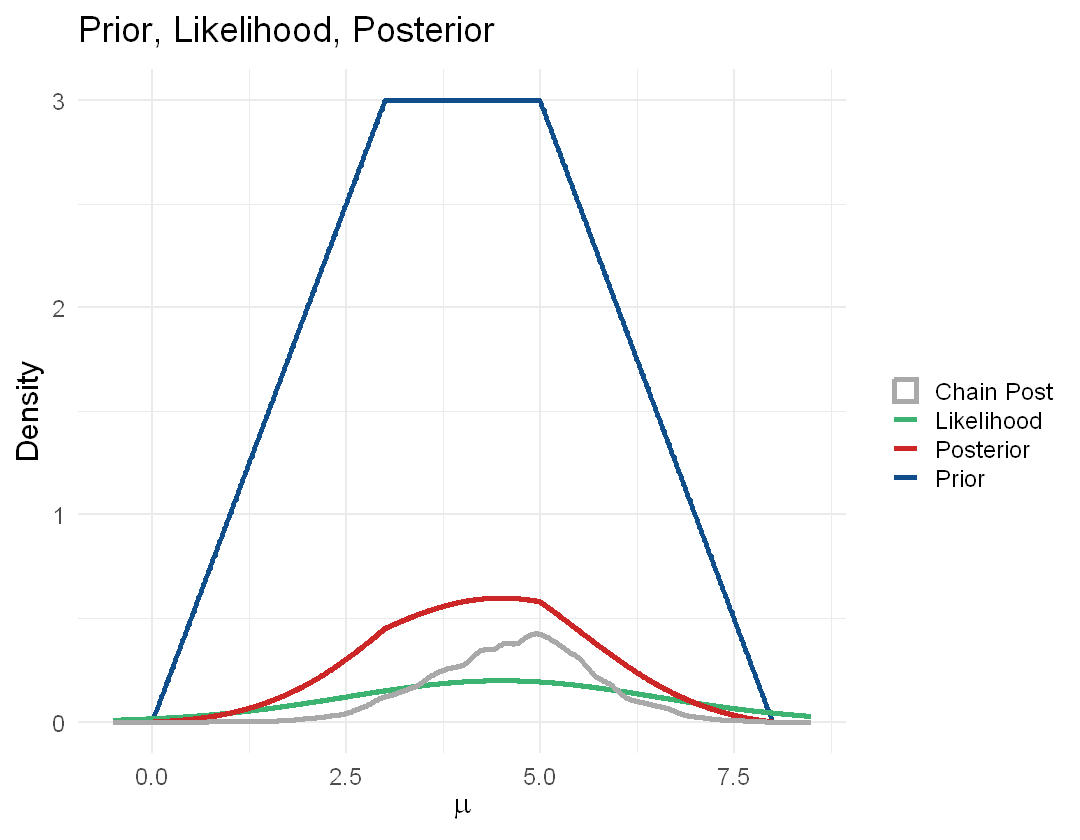

In [13]:
mu.d <- seq(-0.5, 8.5, length.out = 1000)
prior.d <- prior(mu.d)

like.d <- likelihood(mu.d, mu.init, sigma2)

post.d <- (prior.d*like.d)
options(repr.plot.width = 9, repr.plot.height = 7)

fin.plot <- ggplot() +
	geom_line(aes(x = mu.d, y = prior.d, color = 'Prior'), lwd=1.5) +
	geom_line(aes(x = mu.d, y = like.d, color = 'Likelihood'), lwd=1.5) +
	geom_line(aes(x=mu.d, y=post.d, color='Posterior'), lwd=1.5) +
	geom_density(aes(x = test.chain$mu, color= 'Chain Post'), lwd = 1.5) +
	labs(title = TeX(r"(Prior, Likelihood, Posterior)"), x = TeX(r"(\mu)"), y = "Density", color='') +
	scale_color_manual(values = c('Prior' = 'dodgerblue4', 'Likelihood' = 'mediumseagreen', 'Posterior' = 'firebrick3', 'Chain Post' = 'darkgrey')) +
	theme_minimal(base_size = 18)

fin.plot

#### 3)

In [14]:
# 1 white
# 0 black

# box id
id <- sample(0:5, 1)
cat('Ramdomly choosen box: H_',id, '\n')

# n° of extractions
n.samples <- 100

extr <- rbinom(n.samples, size=1, prob=id/5)
cat('Sequence of extracted balls:', extr)

# func to obtain P(E_w|H_i) and P(E_b|H_i)
p.star <- function(i, j) {

	if (i==1) {
		return(j/5)
	} else {
		return((5-j)/5)
	}
}


post.H <- rep(1/5, times=6)

# posterior vectors
pH_0 <- c()
pH_1 <- c()
pH_2 <- c()
pH_3 <- c()
pH_4 <- c()
pH_5 <- c()

# for each extraction, it updates the posterior
for (i in extr) {
    
    post.star <- c()

	for (j in 1:6) {

		post.star <- c(post.star, p.star(i, (j-1))*post.H[j])
	}

	post.H <- post.star/sum(post.star)
    
    
    pH_0 <- c(pH_0, post.H[1])
    pH_1 <- c(pH_1, post.H[2])
    pH_2 <- c(pH_2, post.H[3])
    pH_3 <- c(pH_3, post.H[4])
    pH_4 <- c(pH_4, post.H[5])
    pH_5 <- c(pH_5, post.H[6])

}

Ramdomly choosen box: H_ 1 
Sequence of extracted balls: 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0

TableGrob (3 x 3) "arrange": 7 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange      gtable[layout]
2 2 (2-2,2-2) arrange      gtable[layout]
3 3 (2-2,3-3) arrange      gtable[layout]
4 4 (3-3,1-1) arrange      gtable[layout]
5 5 (3-3,2-2) arrange      gtable[layout]
6 6 (3-3,3-3) arrange      gtable[layout]
7 7 (1-1,1-3) arrange text[GRID.text.505]

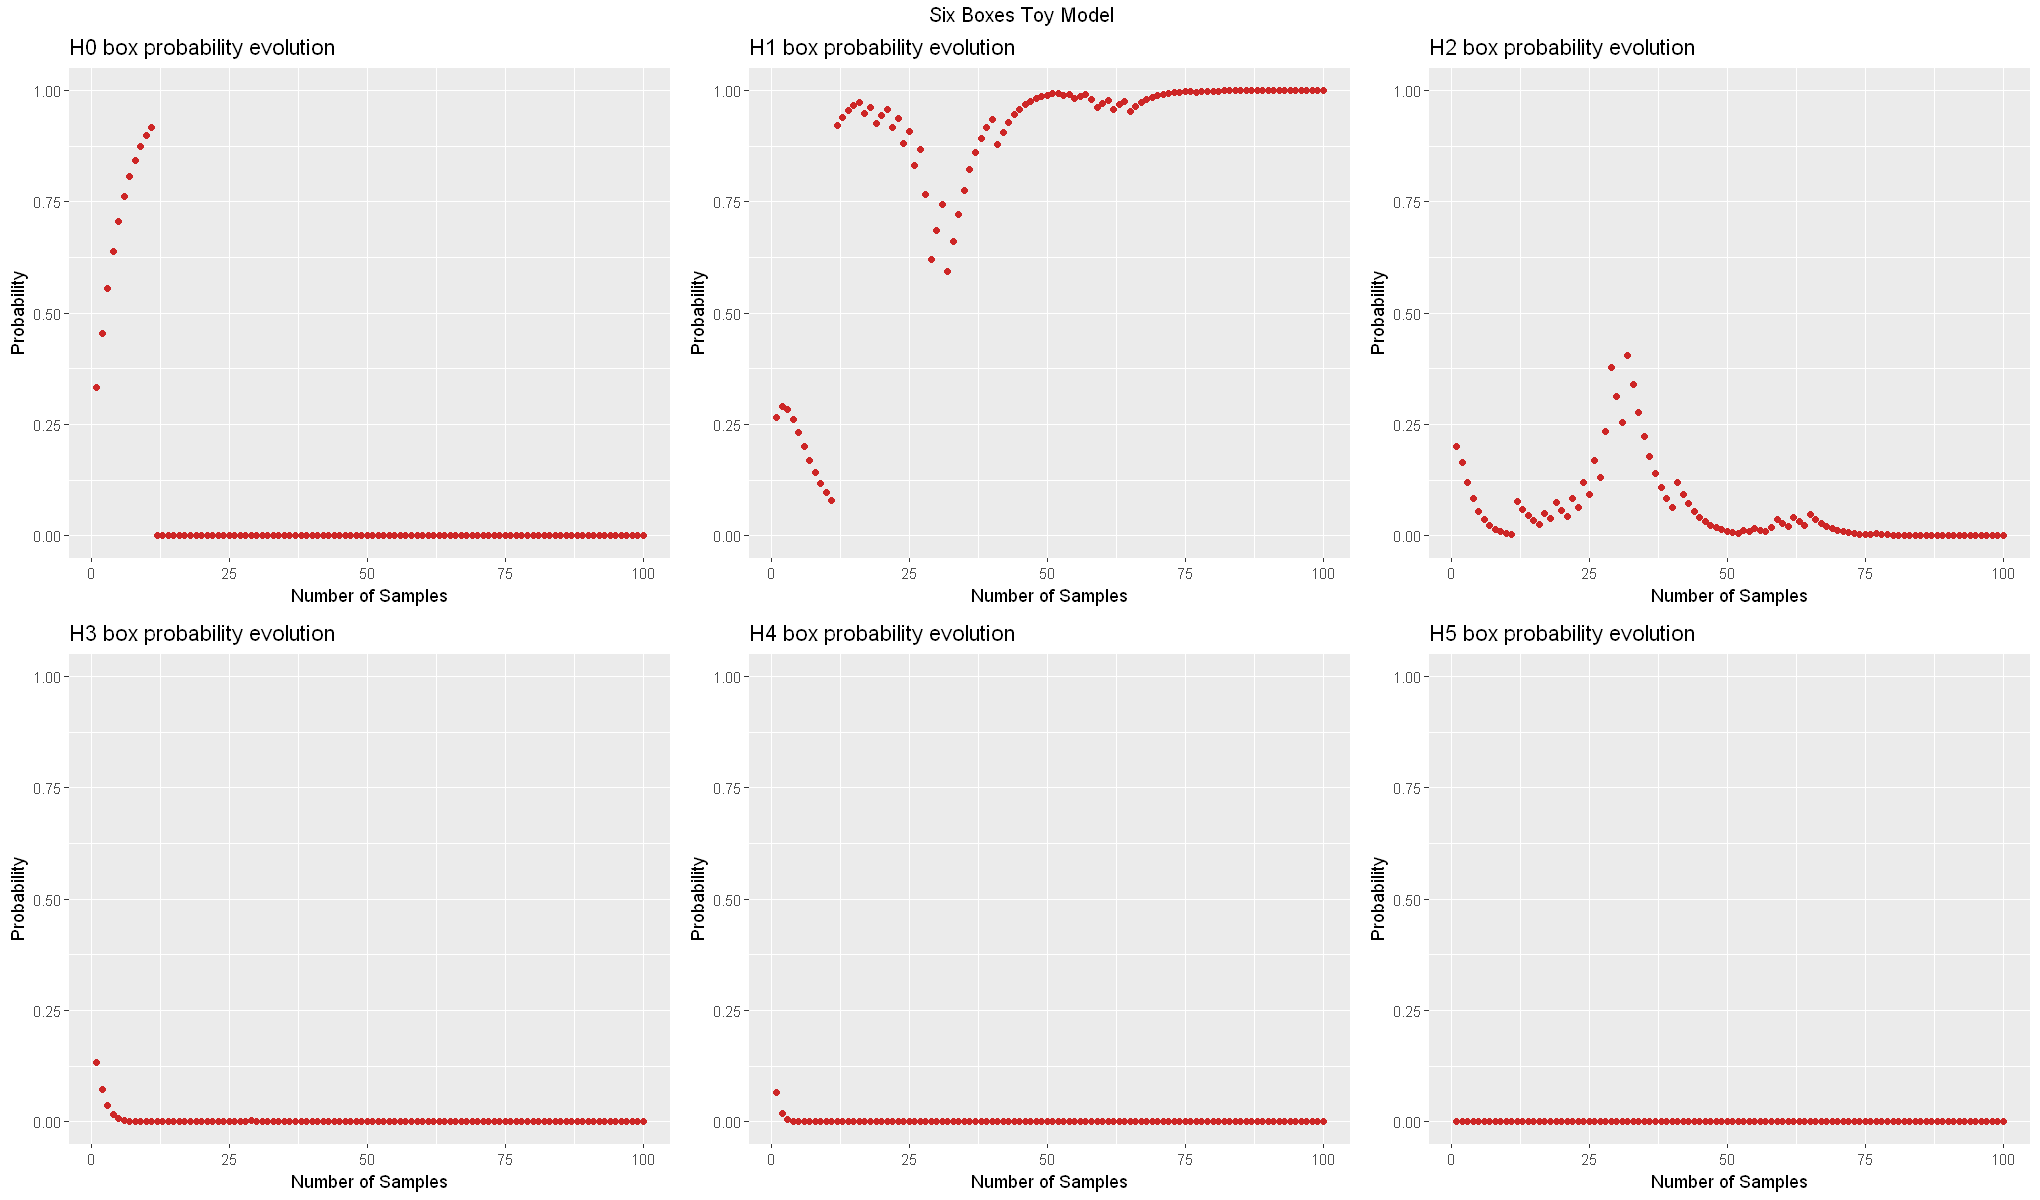

In [15]:
p0 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_0), color='firebrick3') + 
	labs(title='H0 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

p1 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_1), color='firebrick3') + 
	labs(title='H1 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

p2 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_2), color='firebrick3') + 
	labs(title='H2 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

p3 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_3), color='firebrick3') + 
	labs(title='H3 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

p4 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_4), color='firebrick3') + 
	labs(title='H4 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

p5 <- ggplot() + 
	geom_point(aes(x=1:n.samples, y=pH_5), color='firebrick3') + 
	labs(title='H5 box probability evolution', x='Number of Samples', y='Probability') +
	ylim(0, 1) + xlim(1, n.samples)

options(repr.plot.width=17, repr.plot.height=10)

grid.4 <- grid.arrange(p0, p1, p2, p3, p4, p5, ncol=3, nrow=2, top=' Six Boxes Toy Model')

grid.4